In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import scipy as sp
import matplotlib.pyplot as plt

np.random.seed(1234)
# read data
df = pd.read_csv('retail_price.csv')
index = ['product_category_name', 'product_id']
column_min = ['unit_price', 'product_score', 'freight_price', 'product_weight_g', 'comp_1', 'ps1', 'comp_2', 'ps2', 'comp_3', 'ps3']
# column_max = []
column_sum = ['customers']

table_min = pd.pivot_table(df, values=column_min, index=index,  aggfunc=np.min)
# table_min = pivot_table(df, values='D', index=index,  aggfunc=np.max)
table_sum = pd.pivot_table(df, values=column_sum, index=index, aggfunc=np.sum)
table = table_min.merge(table_sum, on=index,how='left')
table

# Selling & Buying & Rating & Probability of buying
product_category = ['bed_bath_table', 'computers_accessories', 'consoles_games', 'cool_stuff', 'furniture_decor']

selling = {}
for category in product_category:
    selling[category] = (table.loc[category]['unit_price'].values)

# we set the margin as a uniform % 
buying = {}
for category in product_category:
    buying[category] = selling[category] * np.random.uniform(0.6,0.7, size = len(selling[category]))


rating = {}
for category in product_category:
    rating[category] = (table.loc[category]['product_score'].values)
MAX_RATING = 5.

# Customers
n_customers = {}
for category in product_category:
    n_customers[category] = (table.loc[category]['customers'].sum())

weights = {}
for category in product_category:
    weights[category] = (table.loc[category]['product_weight_g'].values)

softmax={}
for category in product_category:
    softmax[category] = (np.exp(-selling[category]*(MAX_RATING - rating[category]) / 100) 
              / np.sum(np.exp(-selling[category]*(MAX_RATING - rating[category])/100)))

prop_customers = softmax['computers_accessories']
max_customers = n_customers['computers_accessories'] *prop_customers

print("Buying prices ", buying)
print('Customers ', n_customers)
print("RRP ", selling)
print("Product ratings ", rating)
print("Weights ", weights)

Buying prices  {'bed_bath_table': array([ 24.29552232,  49.00360491,  54.6563085 ,  29.96037386,
       110.78392988]), 'computers_accessories': array([41.61372347, 48.89365655, 90.44449434, 79.66454029, 53.05125824,
       95.30368088]), 'consoles_games': array([12.9369803 , 13.30009124]), 'cool_stuff': array([57.53073324, 74.48574951, 19.35552875, 87.78511965, 50.93210844]), 'furniture_decor': array([23.70489318, 48.10966192, 22.01052454, 51.95448642])}
Customers  {'bed_bath_table': 3313, 'computers_accessories': 4807, 'consoles_games': 439, 'cool_stuff': 2168, 'furniture_decor': 2495}
RRP  {'bed_bath_table': array([ 39.24      ,  74.        ,  84.9       ,  44.15444444,
       163.3987097 ]), 'computers_accessories': array([ 66.34214286,  77.9       , 132.97      , 114.4911538 ,
        77.155     , 149.9       ]), 'consoles_games': array([19.9, 19.9]), 'cool_stuff': array([ 85.70428571, 116.9275    ,  29.5       , 134.99      ,
        84.6925    ]), 'furniture_decor': array([35.  

In [2]:
# fixed freight cost, can change if needed
SHIPPING_COST = 0

# how many customers we have that won't buy unless extra conditions are fufilled
MARKET_CUSTOMERS = {category: n_customers[category] / np.random.uniform(0.4,0.8) for category in product_category}

# what % of 'market' customers do we get for each % of discount?
DISCOUNT_FACTOR = 0

# what % of 'market' customers do we get if we have free shipping
FREE_SHIPPING_FACTOR = 0

# the budget
BUDGET = 1e6

# inventory for each category, we will set this to be a proportion of the number of customers
INVENTORY_SPACE = n_customers['computers_accessories'] * 0.75

BULK_PURCHASE_COST = 1e3
BULK_WEIGHT = 1e4

In [3]:
MARKET_CUSTOMERS

{'bed_bath_table': 7701.919727878018,
 'computers_accessories': 8779.433986623599,
 'consoles_games': 567.7291567613049,
 'cool_stuff': 3282.1071431949727,
 'furniture_decor': 4464.277478038352}

Text(0, 0.5, 'Product Category')

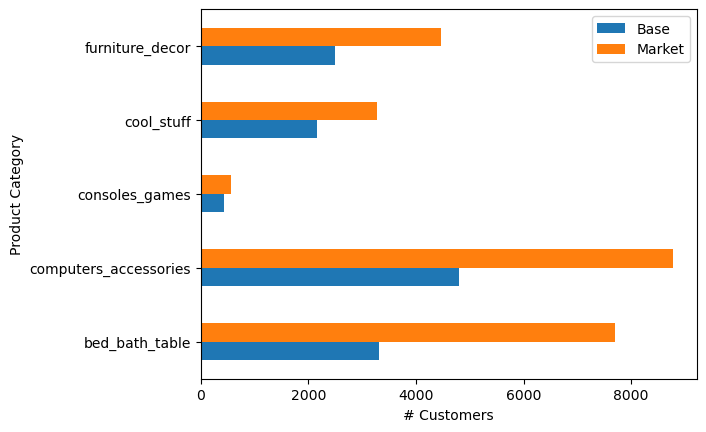

In [4]:
pd.DataFrame([n_customers, MARKET_CUSTOMERS], index = ['Base', 'Market']).T.plot.barh()
plt.xlabel('# Customers')
plt.ylabel('Product Category')

In [15]:
def run_model():
    m = gp.Model()

    BIGNUM = 1e6 # sum(n_customers.values())

    # decision variables
    stock = {}
    is_chosen = {}
    sold = {}
    discount = {}
    free_shipping = {}
    transport_multiplier = {}
    vars = {
        'stock':stock, 'is_chosen':is_chosen, 'sold':sold, 'discount':discount, 'free_shipping':free_shipping,
    }

    # initialising decision variables
    for category in product_category:
        I = range(len(selling[category]))
        stock[category] = m.addVars(I,vtype = GRB.INTEGER)
        is_chosen[category] = m.addVars(I, vtype = GRB.BINARY)
        sold[category] = m.addVars(I,vtype = GRB.INTEGER)
        discount[category] = m.addVars(I,vtype=GRB.CONTINUOUS, lb=0, ub=1)
        free_shipping[category] = m.addVars(I,  vtype = GRB.BINARY)
        transport_multiplier[category] = m.addVar(vtype = GRB.INTEGER)

    # amount sold and extra customers
    captured_customers = lambda category,i: (
        MARKET_CUSTOMERS[category] * (FREE_SHIPPING_FACTOR * free_shipping[category][i]
                                    + DISCOUNT_FACTOR * discount[category][i])
    )
    amount_sold  = lambda category,i: softmax[category][i]* (n_customers[category] + captured_customers(category,i))

    # objective function
    m.setObjective(
        gp.quicksum(gp.quicksum(sold[category][i] * selling[category][i] * (1 - discount[category][i]) 
                                - stock[category][i] * buying[category][i]
                                - sold[category][i] * SHIPPING_COST * free_shipping[category][i]
                    for i in range(len(selling[category]))) 
                    - BULK_PURCHASE_COST * transport_multiplier[category] for category in product_category),
        GRB.MAXIMIZE
    )

    # Can't store past inventory space
    m.addConstrs( gp.quicksum(stock[category][i] for i in range(len(selling[category]))) <= INVENTORY_SPACE 
                for category in product_category)

    # Can't buy more than the budget
    m.addConstr(gp.quicksum( gp.quicksum(stock[category][i] * buying[category][i] for i in range(len(selling[category]))) 
                            for category in product_category) <= BUDGET)

    for category in product_category:
        # If a product is stocked, is_chosen is set to be 1 [Change to BIGNUM to remove dependencies on n_customers]
        m.addConstrs(stock[category][i] <= is_chosen[category][i] * BIGNUM
                    for i in range(len(selling[category])))
        # Can't sell more than you have stocked
        m.addConstrs(sold[category][i] <= stock[category][i] for i in range(len(selling[category])))
        # How much we can sell depends on number of customers [Removed is_chosen]
        m.addConstrs(sold[category][i] <= amount_sold(category, i)
                    for i in range(len(selling[category])))
        m.addConstrs((FREE_SHIPPING_FACTOR * free_shipping[category][i]
                                    + DISCOUNT_FACTOR * discount[category][i]) <= 1 for i in range(len(selling[category])))
        m.addConstrs(transport_multiplier[category] >= (1 / BULK_WEIGHT) * gp.quicksum(stock[category][i] * weights[category][i]
                                                                    for i in range(len(selling[category])))
                                                                    for category in product_category)

    m.params.NonConvex = 2
    m.optimize()
    data = {}
    for category in product_category:
        data[category] = {}
        for v in vars:
            data[category][v] = [a.X for a in vars[v][category].values()]
        data[category]['transport_units'] = transport_multiplier[category].X
        data[category]['captured_customers'] = [captured_customers(category, i).getValue() for i in range(len(selling[category]))]
        data[category]['total_sold'] = [amount_sold(category,i).getValue() for i in range(len(selling[category]))]

    return m,data


In [16]:
n_customers 

{'bed_bath_table': 3313,
 'computers_accessories': 4807,
 'consoles_games': 439,
 'cool_stuff': 2168,
 'furniture_decor': 2495}

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i5-12600K, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 119 rows, 115 columns and 333 nonzeros
Model fingerprint: 0x00a586b7
Model has 22 quadratic objective terms
Variable types: 22 continuous, 93 integer (44 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [1e+01, 2e+02]
  QObjective range [4e+01, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
Found heuristic solution: objective -0.0000000
Presolve removed 118 rows and 113 columns
Presolve time: 0.10s
Presolved: 3 rows, 3 columns, 6 nonzeros
Presolved model has 1 bilinear constraint(s)
Found heuristic solution: objective 547996.90354
Variable types: 2 continuous, 1 integer (0 binary)
Found heuristic solution: objective 564875.98324

Root relaxation: obj

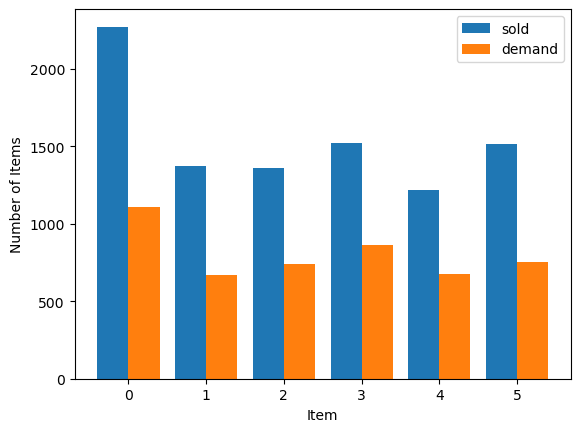

In [17]:
BUDGET = 1e9

# inventory for each category, we will set this to be a proportion of the number of customers
INVENTORY_SPACE = n_customers['computers_accessories'] * 100
MARKET_CUSTOMERS = {category: 20000 for category in product_category}
BULK_PURCHASE_COST = 0
BULK_WEIGHT = 1
DISCOUNT_FACTOR = 2
m,data = run_model()
# the budget

sold_items = data['computers_accessories']['sold']
plt.bar(np.arange(6) - 0.2, sold_items, 0.4, label = 'sold')
plt.bar(np.arange(6) + 0.2, max_customers, 0.4, label = 'demand')
plt.legend()
plt.xlabel("Item")
plt.ylabel("Number of Items")
print("Total amount sold: ", np.sum(sold_items))

In [18]:
data

{'bed_bath_table': {'stock': [2575.0, 1532.0, 853.0, 2335.0, 1249.0],
  'is_chosen': [1.0, 1.0, 1.0, 1.0, 1.0],
  'sold': [2575.0, 1532.0, 853.0, 2335.0, 1249.0],
  'discount': [0.14898951426356544,
   0.12741759570456815,
   0.13681553512897507,
   0.11930993247108027,
   0.11961094178409305],
  'free_shipping': [0.0, 0.0, 0.0, 0.0, 0.0],
  'transport_units': 18387906.0,
  'captured_customers': [5959.580570542617,
   5096.703828182726,
   5472.621405159003,
   4772.397298843211,
   4784.437671363722],
  'total_sold': [2574.9999999999995,
   1532.0,
   853.0,
   2334.9999999999995,
   1248.9999999999995]},
 'computers_accessories': {'stock': [2271.0,
   1370.0,
   1359.0,
   1519.0,
   1216.0,
   1517.0],
  'is_chosen': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  'sold': [2271.0, 1370.0, 1359.0, 1519.0, 1216.0, 1517.0],
  'discount': [0.1262565549877969,
   0.1261750114947781,
   0.09989633217969926,
   0.09200268275091016,
   0.0960532103513689,
   0.12195561117860945],
  'free_shipping': [0.0,

In [50]:
BUDGET = 1e10
disc_results = {}
for c in [10000,1e5, 1e6, 1e7, 1e8]:

    # inventory for each category, we will set this to be a proportion of the number of customers
    INVENTORY_SPACE = n_customers['computers_accessories'] * 100
    MARKET_CUSTOMERS = {category: c for category in product_category}
    BULK_PURCHASE_COST = 0
    BULK_WEIGHT = 1
    DISCOUNT_FACTOR = 5
    m,data = run_model();
    # the budget

    sold_items = data['computers_accessories']['sold']
    # plt.bar(np.arange(6) - 0.2, sold_items, 0.4, label = 'sold')
    # plt.bar(np.arange(6) + 0.2, max_customers, 0.4, label = 'demand')
    # plt.legend()
    # plt.xlabel("Item")
    # plt.ylabel("Number of Items")
    disc_results[c] = data['computers_accessories']['discount']
    print(f"Discout at {c} customers: ", data['computers_accessories']['discount'])

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i5-12600K, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 27 rows, 31 columns and 61 nonzeros
Model fingerprint: 0x49773d08
Model has 6 quadratic objective terms
Variable types: 6 continuous, 25 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [4e+01, 1e+02]
  QObjective range [1e+02, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective -0.0000000
Presolve removed 26 rows and 29 columns
Presolve time: 0.19s
Presolved: 3 rows, 3 columns, 6 nonzeros
Presolved model has 1 bilinear constraint(s)
Found heuristic solution: objective 189846.65753
Variable types: 2 co

In [51]:
disc_results

{10000: [0.14232674823477878,
  0.12079186413671555,
  0.13005252155158484,
  0.11271323979536593,
  0.11297544027402134,
  0.1393270210200511],
 100000.0: [0.18561274557888424,
  0.16408973073281424,
  0.17330916175878489,
  0.15592649728884705,
  0.15619889604312867,
  0.18162608773221003],
 1000000.0: [0.07900873219561724,
  0.07427137606513232,
  0.12140279490626234,
  0.09626319137718467,
  0.06558140918161828,
  0.13700037658427344],
 10000000.0: [0.0, 0.0, 0.017853408934665353, 0.0, 0.0, 0.043592054764168504],
 100000000.0: [0.0, 0.0, 0.0, 0.0, 0.0, 0.006128404973798555]}

In [38]:
(1-np.array(disc_results[50000])) * selling['computers_accessories']

array([ 55.30322057,  66.6171009 , 112.48049506,  98.8399863 ,
        66.58992283, 125.59068132])

In [37]:
buying['computers_accessories']

array([41.07586679, 51.58622733, 85.60246575, 77.68635332, 52.31090335,
       94.02616315])

In [39]:
data

{'computers_accessories': {'stock': [9328.0,
   5030.0,
   5871.0,
   6184.0,
   4865.0,
   6221.0],
  'is_chosen': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  'sold': [9328.0, 5030.0, 5871.0, 6184.0, 4865.0, 6221.0],
  'discount': [0.17840564684510526,
   0.15686143179835538,
   0.16611051747270264,
   0.14872428770660018,
   0.14898313213148184,
   0.17455360015057733],
  'free_shipping': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  'transport_units': 52760254.0}}

In [41]:
np.sum(np.array(data['computers_accessories']['sold']) * (1-np.array(disc_results[50000])) * selling['computers_accessories'])

3227811.523942728

In [43]:
BUDGET

1000000000.0